In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import torchvision.models as models
from torchvision import transforms
import random
import cv2

In [2]:
class GRL(nn.Module):
    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff * gradOutput


class adaIN(nn.Module):

    def __init__(self, eps=1e-5):
        super(adaIN, self).__init__()
        self.eps = eps

    def forward(self, input, gamma, beta):
        in_mean, in_var = torch.mean(input, dim=[2, 3], keepdim=True), torch.var(input, dim=[2, 3], keepdim=True)
        out_in = (input - in_mean) / torch.sqrt(in_var + self.eps)
        out = out_in
        out = out * gamma.unsqueeze(2).unsqueeze(3) + beta.unsqueeze(2).unsqueeze(3)
        return out

class ResnetAdaINBlock(nn.Module):

    def __init__(self, dim):
        super(ResnetAdaINBlock, self).__init__()
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = adaIN()
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = adaIN()

    def forward(self, x, gamma, beta):
        out = self.conv1(x)
        out = self.norm1(out, gamma, beta)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)
        return out+x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, max_iter):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 3)
        self.ad_net = nn.Sequential(
            self.fc1,
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            self.fc2
        )
        self.grl_layer = GRL(max_iter)

    def forward(self, feature):
        adversarial_out = self.ad_net(self.grl_layer(feature))
        return adversarial_out

class SSAN_R(nn.Module):
    def __init__(self, ada_num=2, max_iter=4000):
        super(SSAN_R, self).__init__()
        model_resnet = models.resnet18(pretrained=True)

        self.input_layer = nn.Sequential(
            model_resnet.conv1,
            model_resnet.bn1,
            model_resnet.relu,
            model_resnet.maxpool
        )
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.adaIN_layers = nn.ModuleList([ResnetAdaINBlock(256) for i in range(ada_num)])

        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        self.cls_head = nn.Linear(512, 2, bias=True)

        self.gamma = nn.Linear(256, 256, bias=False)
        self.beta = nn.Linear(256, 256, bias=False)

        self.FC = nn.Sequential(
            nn.Linear(256, 256, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ada_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.ada_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.ada_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256)
        )
        self.dis = Discriminator(max_iter)

    def cal_gamma_beta(self, x1):
        x1 = self.input_layer(x1)
        x1_1 = self.layer1(x1)
        x1_2 = self.layer2(x1_1)
        x1_3 = self.layer3(x1_2)

        x1_4 = self.layer4(x1_3) # content feature
        
        x1_add = x1_1
        x1_add = self.ada_conv1(x1_add)+x1_2
        x1_add = self.ada_conv2(x1_add)+x1_3
        x1_add = self.ada_conv3(x1_add) # style feature tổng hợp

        gmp = torch.nn.functional.adaptive_max_pool2d(x1_add, 1)
        gmp_ = self.FC(gmp.view(gmp.shape[0], -1))
        gamma, beta = self.gamma(gmp_), self.beta(gmp_) # gamma, beta từ style feature

        domain_invariant = torch.nn.functional.adaptive_avg_pool2d(x1_4, 1).reshape(x1_4.shape[0], -1) #embedding dùng trong L_adv

        return x1_4, gamma, beta, domain_invariant

    def forward(self, input1, input2):
        x1, gamma1, beta1, domain_invariant = self.cal_gamma_beta(input1)
        x2, gamma2, beta2, _ = self.cal_gamma_beta(input2)

        # Self-assembly S(xi, xi)
        fea_x1_x1 = x1
        for i in range(len(self.adaIN_layers)):
            fea_x1_x1 = self.adaIN_layers[i](fea_x1_x1, gamma1, beta1)
        fea_x1_x1 = self.conv_final(fea_x1_x1)
        fea_x1_x1 = torch.nn.functional.adaptive_avg_pool2d(fea_x1_x1, 1)
        fea_x1_x1 = fea_x1_x1.reshape(fea_x1_x1.shape[0], -1)
        cls_x1_x1 = self.cls_head(fea_x1_x1)

        # Shuffle-assembly S(xi, xi*)
        fea_x1_x2 = x1
        for i in range(len(self.adaIN_layers)):
            fea_x1_x2 = self.adaIN_layers[i](fea_x1_x2, gamma2, beta2)
        fea_x1_x2 = self.conv_final(fea_x1_x2)
        fea_x1_x2 = torch.nn.functional.adaptive_avg_pool2d(fea_x1_x2, 1)
        fea_x1_x2 = fea_x1_x2.reshape(fea_x1_x2.shape[0], -1)

        dis_invariant = self.dis(domain_invariant)
        return cls_x1_x1, fea_x1_x1, fea_x1_x2, dis_invariant

In [4]:
class ContrastLoss(nn.Module):
    
    def __init__(self):
        super(ContrastLoss, self).__init__()
        pass

    def forward(self, anchor_fea, reassembly_fea, contrast_label):
        contrast_label = contrast_label.float()
        anchor_fea = anchor_fea.detach()
        loss = -(F.cosine_similarity(anchor_fea, reassembly_fea, dim=-1))
        loss = loss*contrast_label
        return loss.mean()

In [5]:
# Imports chung

import os
import math
import random
import time

import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# Cấu hình 

from types import SimpleNamespace

cfg = SimpleNamespace()

# Đường dẫn dữ liệu của bạn
cfg.data_dir      = "./dataset_processed"  # chỉnh nếu khác
cfg.result_path   = "./results"            # nơi lưu model, score, csv
cfg.result_name   = "ssan_custom"          # tên run

# Training settings
cfg.model_type    = "SSAN_R"   # hiện tại chỉ dùng SSAN_R (binary)
cfg.batch_size    = 16
cfg.img_size      = 256
cfg.map_size      = 32
cfg.num_epochs    = 20          # bạn tăng sau
cfg.start_epoch   = 0
cfg.print_freq    = 10

# Optimizer & scheduler
cfg.base_lr       = 1e-4
cfg.momentum      = 0.9
cfg.weight_decay  = 5e-5
cfg.step_size     = 500        # giống solver.py – bước giảm lr theo epoch
cfg.gamma         = 0.5

# Augmentation mode: "o" (original), "p" (pure), "I" (ImageNet)
cfg.trans         = "p"

# Debug: nếu muốn chỉ dùng một phần nhỏ dataset
cfg.debug_subset_size = None   # hoặc ví dụ = 200

# Domain: hiện tại chỉ có 1 domain CUSTOM, id = 0
DOMAIN_NAME_TO_ID = {
    "CUSTOM": 0,
    # sau này bạn thêm: "CASIA": 1, "OULU": 2, ...
}
cfg.num_domains = len(DOMAIN_NAME_TO_ID)

cfg.early_stop_patience = 5       # dừng nếu không cải thiện sau 5 epoch
cfg.monitor_metric = "auc"        # "auc" hoặc "acc" hoặc "auc-hter"

cfg


namespace(data_dir='./dataset_processed',
          result_path='./results',
          result_name='ssan_custom',
          model_type='SSAN_R',
          batch_size=16,
          img_size=256,
          map_size=32,
          num_epochs=20,
          start_epoch=0,
          print_freq=10,
          base_lr=0.0001,
          momentum=0.9,
          weight_decay=5e-05,
          step_size=500,
          gamma=0.5,
          trans='p',
          debug_subset_size=None,
          num_domains=1,
          early_stop_patience=5,
          monitor_metric='auc')

In [ ]:
import csv
import os

# Tạo thư mục log
log_dir = os.path.join(cfg.result_path, cfg.result_name, "log")
os.makedirs(log_dir, exist_ok=True)

log_csv_path = os.path.join(log_dir, "training_log.csv")

# Tạo CSV header nếu file chưa tồn tại
if not os.path.exists(log_csv_path):
    with open(log_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch", 
            "train_ce", "train_contra", "train_adv", "train_total",
            "val_acc", "val_auc", "val_hter",
            "epoch_time"
        ])

# Biến history để vẽ biểu đồ
history = {
    "epoch": [],
    "train_total": [],
    "train_ce": [],
    "train_contra": [],
    "train_adv": [],
    "val_acc": [],
    "val_auc": [],
    "val_hter": [],
    "epoch_time": [],
}


In [9]:
# Transforms cho training / testing

class Normaliztion(object):
    """
    Chuẩn hóa ảnh về [-1, 1]: image = (image - 127.5) / 128
    Đồng thời map_x về [0,1]
    """
    def __call__(self, sample):
        image_x = sample['image_x']
        map_x   = sample['map_x']
        image_x = (image_x - 127.5) / 128.0
        sample['image_x'] = image_x
        sample['map_x']   = map_x / 255.0
        return sample


class Normaliztion_ImageNet(object):
    # Chuẩn hóa theo mean/std ImageNet
    def __init__(self):
        self.trans = transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __call__(self, sample):
        image_x = sample['image_x'] / 255.0
        image_x = self.trans(image_x)
        sample['image_x'] = image_x
        map_x = sample['map_x']
        sample['map_x'] = map_x / 255.0
        return sample


class ToTensor(object):
    # Convert numpy image HxWxC (BGR/RGB) -> torch Tensor CxHxW
    def __call__(self, sample):
        image_x, map_x, spoofing_label = sample['image_x'], sample['map_x'], sample['label']
        # Chuyển từ HxWxC (BGR) sang CxHxW (RGB)
        image_x = image_x[:, :, ::-1].transpose((2, 0, 1))  # BGR -> RGB, HWC -> CHW
        image_x = np.array(image_x)
        map_x   = np.array(map_x)

        spoofing_label_np = np.array([0], dtype=np.longlong)
        spoofing_label_np[0] = spoofing_label

        sample['image_x'] = torch.from_numpy(image_x.astype(np.float32)).float()
        sample['map_x']   = torch.from_numpy(map_x.astype(np.float32)).float()
        sample['label']   = torch.from_numpy(spoofing_label_np).long()
        return sample


class Cutout(object):
    def __init__(self, length=50):
        self.length = length

    def __call__(self, sample):
        img = sample['image_x']
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        length_new = np.random.randint(1, self.length)
        y1 = np.clip(y - length_new // 2, 0, h)
        y2 = np.clip(y + length_new // 2, 0, h)
        x1 = np.clip(x - length_new // 2, 0, w)
        x2 = np.clip(x + length_new // 2, 0, w)
        mask[y1:y2, x1:x2] = 0.0
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        img *= mask
        sample['image_x'] = img
        return sample


class RandomHorizontalFlip(object):
    def __call__(self, sample):
        if random.random() < 0.5:
            image_x = sample["image_x"]
            map_x   = sample["map_x"]
            image_x = cv2.flip(image_x, 1)
            map_x   = cv2.flip(map_x, 1)
            sample["image_x"] = image_x
            sample["map_x"]   = map_x
        return sample


class Contrast_and_Brightness(object):
    def __call__(self, sample):
        image_x = sample["image_x"]
        gamma = random.randint(-40, 40)
        alpha = random.uniform(0.5, 1.5)
        image_x = cv2.addWeighted(image_x, alpha, image_x, 0, gamma)
        sample["image_x"] = image_x
        return sample


def transformer_train():
    return transforms.Compose([
        Contrast_and_Brightness(),
        RandomHorizontalFlip(),
        ToTensor(),
        Cutout(),
        Normaliztion(),
    ])


def transformer_train_pure():
    return transforms.Compose([
        RandomHorizontalFlip(),
        ToTensor(),
        Normaliztion(),
    ])


def transformer_train_ImageNet():
    return transforms.Compose([
        RandomHorizontalFlip(),
        ToTensor(),
        Normaliztion_ImageNet(),
    ])


def transformer_test_image():
    """
    Transform dùng cho test trên ảnh đơn (không augment), 
    tương tự Normaliztion + ToTensor (không Flip, không Cutout).
    """
    return transforms.Compose([
        ToTensor(),
        Normaliztion(),
    ])


In [10]:
# Dataset

class CustomImageDataset(Dataset):
    """
    Giả định list_filtered.csv có cột:
      - label: 1 (live), 0 (not_live)
      - path: đường dẫn tương đối từ data_dir (vd: live/anh1.jpg)
      - domain: tên miền (vd: CUSTOM)
    """
    def __init__(self, csv_file, root_dir, transform=None, img_size=256, map_size=32, default_domain="CUSTOM"):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size
        self.map_size = map_size
        self.default_domain = default_domain

        # Nếu file csv KHÔNG có cột domain, ta thêm domain mặc định
        if "domain" not in self.data.columns:
            self.data["domain"] = default_domain  # = CUSTOM

        # Nếu CSV có cột 'filename' thì dùng nó làm path
        if "path" not in self.data.columns:
            if "filename" in self.data.columns:
                self.data["path"] = self.data["filename"]
            else:
                raise ValueError("CSV cần cột 'path' hoặc 'filename'.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row   = self.data.iloc[idx]
        rel_path = row["path"]
        label = int(row["label"])
        domain_name = row["domain"]

        img_path = os.path.join(self.root_dir, rel_path)

        # đọc ảnh BGR
        image_x = cv2.imread(img_path)
        if image_x is None:
            raise RuntimeError(f"Không đọc được ảnh: {img_path}")
        image_x = cv2.resize(image_x, (self.img_size, self.img_size))

        # SSAN_R không dùng map_x nhưng solver yêu cầu, ta cho zeros
        map_x = np.zeros((self.map_size, self.map_size), dtype=np.float32)

        UUID = DOMAIN_NAME_TO_ID.get(domain_name, 0)

        sample = {
            "image_x": image_x,
            "map_x": map_x,
            "label": label,
            "UUID": UUID,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


In [11]:
# Utils, optimizer, metrics

# AvgrageMeter & check_folder
class AvgrageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        val = float(val)
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt if self.cnt != 0 else 0.0


def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir


# Optimizer
def get_optimizer(name, model, lr, momentum=0.9, weight_decay=0.0005):
    if name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise NotImplementedError
    return optimizer


# Metrics HTER, AUC
from sklearn.metrics import roc_curve, auc

def get_err_threhold(fpr, tpr, threshold):
    differ_tpr_fpr_1 = tpr + fpr - 1.0
    right_index = np.argmin(np.abs(differ_tpr_fpr_1))
    best_th = threshold[right_index]
    err = fpr[right_index]
    return err, best_th, right_index

def performances_val_from_scores(scores, labels):
    """
    Tính trực tiếp từ list scores, labels.
    scores: list/ndarray float (score lớn = live)
    labels: list/ndarray float (1=live,0=spoof)
    """
    fpr, tpr, threshold = roc_curve(labels, scores, pos_label=1)
    auc_test = auc(fpr, tpr)
    val_err, val_threshold, right_index = get_err_threhold(fpr, tpr, threshold)

    # type1, type2: giống performance.py
    data = [{'score': s, 'label': l} for s, l in zip(scores, labels)]
    type1 = len([d for d in data if d['score'] < val_threshold and d['label'] == 1])
    type2 = len([d for d in data if d['score'] > val_threshold and d['label'] == 0])
    count = len(data)
    val_ACC = 1 - (type1 + type2) / count if count > 0 else 0.0

    FRR = 1 - tpr  # FRR = 1 - TPR
    HTER = (fpr + FRR) / 2.0

    return val_ACC, fpr[right_index], FRR[right_index], HTER[right_index], auc_test, val_err


In [12]:
# Khởi tạo DataLoader, model, optimizer, scheduler

# Chọn transform train theo cfg.trans
if cfg.trans == "o":
    train_transform = transformer_train()
elif cfg.trans == "p":
    train_transform = transformer_train_pure()
elif cfg.trans == "I":
    train_transform = transformer_train_ImageNet()
else:
    raise ValueError(f"Unknown trans mode: {cfg.trans}")

test_transform = transformer_test_image()

csv_path = os.path.join(cfg.data_dir, "list_filtered.csv")

full_dataset = CustomImageDataset(
    csv_file=csv_path,
    root_dir=cfg.data_dir,
    transform=None,  # sẽ áp dụng transform riêng cho train/test
    img_size=cfg.img_size,
    map_size=cfg.map_size,
)

# Tạm thời chia train/test bằng split đơn giản 80/20
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]

train_subset = torch.utils.data.Subset(full_dataset, train_idx)
test_subset  = torch.utils.data.Subset(full_dataset, test_idx)

# Gán transform cho từng subset bằng cách bọc lại
class TransformWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        sample = self.subset[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

train_set = TransformWrapper(train_subset, train_transform)
test_set  = TransformWrapper(test_subset,  test_transform)

if cfg.debug_subset_size is not None:
    train_set = torch.utils.data.Subset(train_set, range(0, min(cfg.debug_subset_size, len(train_set))))
    test_set  = torch.utils.data.Subset(test_set,  range(0, min(cfg.debug_subset_size,  len(test_set))))

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_set,  batch_size=cfg.batch_size, shuffle=False, num_workers=0)

print("Train samples:", len(train_set))
print("Test samples :", len(test_set))

# Khởi tạo model SSAN_R
max_iter = cfg.num_epochs * max(1, len(train_loader))
model = SSAN_R(max_iter=max_iter).to(device)

# Optimizer & scheduler
optimizer = get_optimizer("adam", model, lr=cfg.base_lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.step_size, gamma=cfg.gamma)

# Loss
binary_fuc = nn.CrossEntropyLoss()  # L_cls (SSAN_R)
contra_fun = ContrastLoss()         # L_contra


Train samples: 3480
Test samples : 870


d:\CODE\face-anti-spoofing-2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODE\face-anti-spoofing-2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop + Validation

def train_one_epoch(epoch, model, train_loader, optimizer):
    model.train()
    binary_loss_meter = AvgrageMeter()
    contra_loss_meter = AvgrageMeter()
    adv_loss_meter    = AvgrageMeter()
    total_loss_meter  = AvgrageMeter()

    start_time = time.time()

    total_batches = len(train_loader)

    for i, batch in enumerate(train_loader):
        progress = 100 * (i + 1) / total_batches

        image_x = batch["image_x"].to(device)
        label   = batch["label"].to(device)
        UUID    = batch["UUID"].to(device)

        rand_idx = torch.randperm(image_x.shape[0], device=device)

        cls_x1_x1, fea_x1_x1, fea_x1_x2, domain_invariant = model(
            image_x, image_x[rand_idx]
        )

        ce_loss = binary_fuc(cls_x1_x1, label[:, 0].long())
        same_label = (label[:, 0] == label[rand_idx, 0]).long()
        contrast_label = torch.where(same_label == 1, 1, -1).to(device)
        contra_loss = contra_fun(fea_x1_x1, fea_x1_x2, contrast_label)
        adv_loss = binary_fuc(domain_invariant, UUID)

        loss_all = ce_loss + contra_loss + adv_loss

        n = image_x.size(0)
        binary_loss_meter.update(ce_loss.item(), n)
        contra_loss_meter.update(contra_loss.item(), n)
        adv_loss_meter.update(adv_loss.item(), n)
        total_loss_meter.update(loss_all.item(), n)

        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()

        # Hiển thị tiến trình chi tiết
        print(
            f"[Epoch {epoch+1}/{cfg.num_epochs}] "
            f"Batch {i+1}/{total_batches} ({progress:.1f}%) "
            f"| CE={binary_loss_meter.avg:.4f} "
            f"| Contra={contra_loss_meter.avg:.4f} "
            f"| Adv={adv_loss_meter.avg:.4f} "
            f"| Total={total_loss_meter.avg:.4f} ",
            end="\r",
        )

    print()
    epoch_time = time.time() - start_time

    return (binary_loss_meter.avg,
            contra_loss_meter.avg,
            adv_loss_meter.avg,
            total_loss_meter.avg,
            epoch_time)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_scores = []
    all_labels = []

    for batch in loader:
        image_x = batch["image_x"].to(device)
        label   = batch["label"].to(device)  # [B,1]

        # Để đơn giản, test dùng self-assembly (không shuffle)
        cls_x1_x1, _, _, _ = model(image_x, image_x)
        # softmax score cho class live (index 1)
        scores = torch.softmax(cls_x1_x1, dim=1)[:, 1]

        all_scores.append(scores.cpu().numpy())
        all_labels.append(label[:, 0].cpu().numpy())

    if not all_scores:
        return 0, 0, 0, 0, 0, 0

    all_scores = np.concatenate(all_scores, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    acc, fpr, FRR, HTER, auc_test, val_err = performances_val_from_scores(all_scores, all_labels)
    print(f"Eval: ACC={acc:.4f}, HTER={HTER:.4f}, AUC={auc_test:.4f}")
    return acc, fpr, FRR, HTER, auc_test, val_err


# Thư mục lưu model
model_root_path = check_folder(os.path.join(cfg.result_path, cfg.result_name, "model"))

best_metric = -1e9
no_improve = 0

for epoch in range(cfg.start_epoch, cfg.num_epochs):

    train_ce, train_contra, train_adv, train_total, epoch_time = \
        train_one_epoch(epoch, model, train_loader, optimizer)

    scheduler.step()

    acc, fpr, FRR, HTER, auc_test, val_err = evaluate(model, test_loader)

    # Lưu vào history để vẽ biểu đồ
    history["epoch"].append(epoch+1)
    history["train_ce"].append(train_ce)
    history["train_contra"].append(train_contra)
    history["train_adv"].append(train_adv)
    history["train_total"].append(train_total)
    history["val_acc"].append(acc)
    history["val_auc"].append(auc_test)
    history["val_hter"].append(HTER)
    history["epoch_time"].append(epoch_time)

    # Save last model
    last_path = os.path.join(model_root_path, "last_model.pth")
    torch.save(model.state_dict(), last_path)

    # --- MONITOR ---
    if cfg.monitor_metric == "auc":
        metric = auc_test
    elif cfg.monitor_metric == "acc":
        metric = acc
    elif cfg.monitor_metric == "auc-hter":
        metric = auc_test - HTER

    if metric > best_metric:
        best_metric = metric
        no_improve = 0
        best_path = os.path.join(model_root_path, "best_model.pth")
        torch.save(model.state_dict(), best_path)
        print(f">>> Best model saved at epoch {epoch+1}")
    else:
        no_improve += 1

    print(f"Epoch time: {epoch_time:.2f}s")
    print(f"No improvement for {no_improve}/{cfg.early_stop_patience} epochs")

    if no_improve >= cfg.early_stop_patience:
        print(">>> EARLY STOPPING triggered!")
        break


[Epoch 1/20] Batch 218/218 (100.0%) | CE=0.2430 | Contra=-0.4576 | Adv=0.1434 | Total=-0.0712 
Eval: ACC=0.9954, HTER=0.0087, AUC=0.9948
>>> Best model saved at epoch 1
Epoch time: 123.04s
No improvement for 0/5 epochs
[Epoch 2/20] Batch 218/218 (100.0%) | CE=0.1487 | Contra=-0.5168 | Adv=0.0016 | Total=-0.3665 
Eval: ACC=0.9931, HTER=0.0101, AUC=0.9916
Epoch time: 126.85s
No improvement for 1/5 epochs
[Epoch 3/20] Batch 218/218 (100.0%) | CE=0.1218 | Contra=-0.8245 | Adv=0.0004 | Total=-0.7023 
Eval: ACC=0.9851, HTER=0.0148, AUC=0.9955
>>> Best model saved at epoch 3
Epoch time: 128.45s
No improvement for 0/5 epochs
[Epoch 4/20] Batch 218/218 (100.0%) | CE=0.0987 | Contra=-0.9091 | Adv=0.0001 | Total=-0.8103 
Eval: ACC=0.9931, HTER=0.0101, AUC=0.9984
>>> Best model saved at epoch 4
Epoch time: 128.72s
No improvement for 0/5 epochs
[Epoch 5/20] Batch 218/218 (100.0%) | CE=0.0621 | Contra=-0.9517 | Adv=0.0001 | Total=-0.8896 
Eval: ACC=0.9690, HTER=0.0311, AUC=0.9949
Epoch time: 128.87s

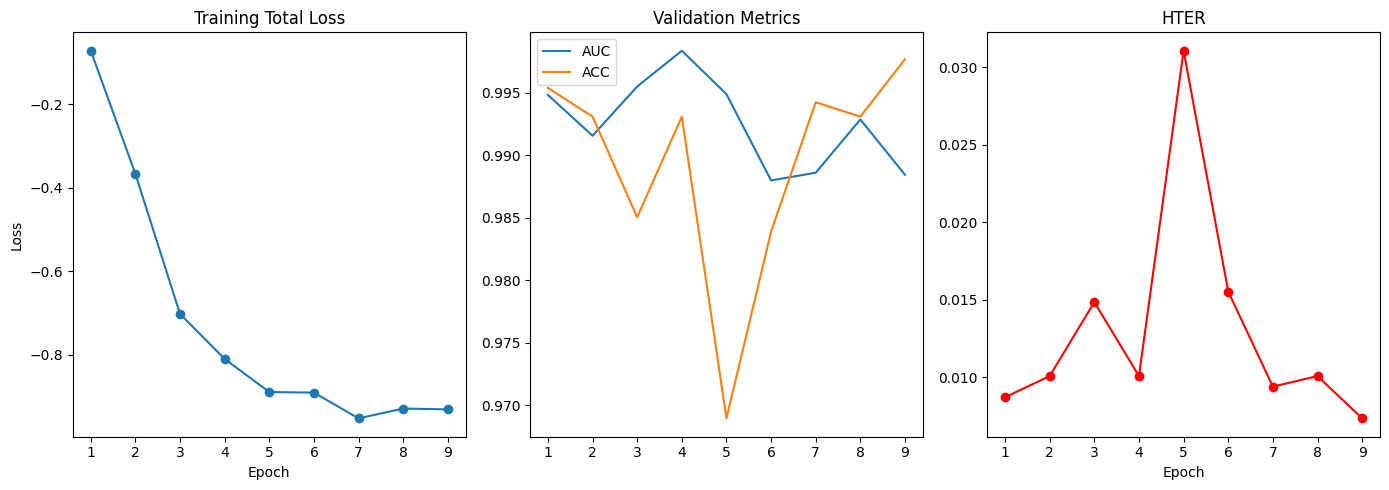

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = history["epoch"]

    plt.figure(figsize=(14,5))

    # Loss plot
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_total"], '-o')
    plt.title("Training Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # AUC & ACC
    plt.subplot(1,3,2)
    plt.plot(epochs, history["val_auc"], label='AUC')
    plt.plot(epochs, history["val_acc"], label='ACC')
    plt.legend()
    plt.title("Validation Metrics")

    # HTER
    plt.subplot(1,3,3)
    plt.plot(epochs, history["val_hter"], '-o', color='red')
    plt.title("HTER")
    plt.xlabel("Epoch")

    plt.tight_layout()
    plt.show()

plot_history(history)

In [12]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# ===== LOAD MODEL SSAN_R =====
def load_ssan_r_model(checkpoint_path, max_iter=10000):
    model = SSAN_R(max_iter=max_iter).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Trường hợp checkpoint lưu dạng dict
    if "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

checkpoint_path = "results/ssan_custom/model/best_model.pth"
model = load_ssan_r_model(checkpoint_path)
print("Model loaded.")

# ===== INFERENCE TRANSFORM =====
test_transform = transformer_test_image()

Model loaded.


C:\Users\Admin\AppData\Local\Temp\ipykernel_2612\1133652112.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)

----------------------------------------
Prediction: LIVE
Live probability: 0.9923
----------------------------------------


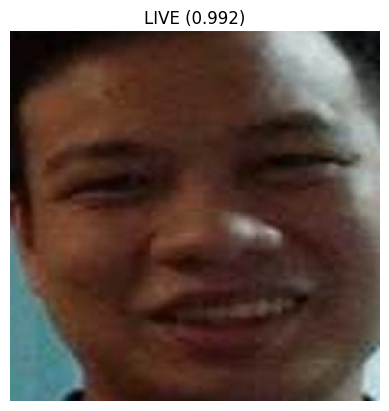

(0.992308497428894, 'LIVE')

In [29]:
# ===== INFERENCE HÀM CHÍNH =====
def infer_image(model, image_path, img_size=256):
    # Load ảnh
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Không load được ảnh: " + image_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))

    # Tạo sample giống dataset train/test
    sample = {
        "image_x": img_resized,
        "map_x": np.zeros((cfg.map_size, cfg.map_size), dtype=np.float32),
        "label": 0,
        "UUID": 0
    }

    # Apply transform
    sample = test_transform(sample)

    # Convert to batch
    image_tensor = sample["image_x"].unsqueeze(0).to(device)

    # Forward qua model (self-assembly)
    with torch.no_grad():
        logits, _, _, _ = model(image_tensor, image_tensor)
        prob = torch.softmax(logits, dim=1)[0, 1].item()  # xác suất live

    pred = "LIVE" if prob >= 0.5 else "SPOOF"

    print("----------------------------------------")
    print(f"Prediction: {pred}")
    print(f"Live probability: {prob:.4f}")
    print("----------------------------------------")

    # Show ảnh
    plt.imshow(img_rgb)
    plt.title(f"{pred} ({prob:.3f})")
    plt.axis("off")
    plt.show()

    return prob, pred

# ===== TEST =====
# Thay bằng ảnh của bạn
infer_image(model, "dataset_processed/photo2/not_live/spoof_1947_val.jpg")


In [23]:
import cv2
import mediapipe as mp
import numpy as np
import torch

mp_face = mp.solutions.face_detection
mp_draw = mp.solutions.drawing_utils

# ==== Hàm preprocess frame để tương thích SSAN_R ====
def preprocess_face(face_img):
    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_resized = cv2.resize(face_rgb, (cfg.img_size, cfg.img_size))

    sample = {
        "image_x": face_resized,
        "map_x": np.zeros((cfg.map_size, cfg.map_size), dtype=np.float32),
        "label": 0,
        "UUID": 0
    }
    sample = test_transform(sample)
    return sample["image_x"].unsqueeze(0).to(device)


# ==== WEBCAM ANTI-SPOOFING ====
def infer_webcam_multiface(model, camera_id=0, score_thres=0.5):
    cap = cv2.VideoCapture(camera_id)
    if not cap.isOpened():
        print("Không mở được webcam!")
        return

    print("Webcam đang chạy... Nhấn 'q' để thoát.")

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.6) as face_detector:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            h, w, _ = frame.shape

            # ----------- Face detection -----------
            results = face_detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if results.detections:
                for detection in results.detections:
                    # Lấy bounding box
                    box = detection.location_data.relative_bounding_box
                    x, y, ww, hh = box.xmin, box.ymin, box.width, box.height

                    x1 = int(x * w)
                    y1 = int(y * h)
                    x2 = int((x + ww) * w)
                    y2 = int((y + hh) * h)

                    # Giới hạn box hợp lệ
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(w, x2)
                    y2 = min(h, y2)

                    # Crop face
                    face_crop = frame[y1:y2, x1:x2]
                    if face_crop.size == 0:
                        continue

                    # ----- Preprocess + inference -----
                    input_tensor = preprocess_face(face_crop)

                    with torch.no_grad():
                        logits, _, _, _ = model(input_tensor, input_tensor)
                        prob_live = torch.softmax(logits, dim=1)[0, 1].item()

                    pred = "LIVE" if prob_live >= score_thres else "SPOOF"
                    color = (0, 255, 0) if pred == "LIVE" else (0, 0, 255)

                    # ----- Vẽ bounding box -----
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

                    # ----- Ghi text -----
                    label = f"{pred} ({prob_live:.2f})"
                    cv2.putText(frame, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            cv2.imshow("SSAN_R Multi-Face Anti-Spoofing", frame)

            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

    cap.release()
    cv2.destroyAllWindows()


# ==== CHẠY WEBCAM ====
infer_webcam_multiface(model)


Webcam đang chạy... Nhấn 'q' để thoát.
